<a href="https://colab.research.google.com/github/journalWheat/CSI4106-Project1/blob/main/CSI4106_Project1_JaredWagner_GeneralForm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting wine quality with naive bayes, logistic regression, and multi-layer perceptron**

# GROUP 97
Intellectual property of JARED WAGNER (Student #300010832), Fall 2022.

Submitted for CSI4106, Introduction to Artificial Intelligence. 

Student #300010832

# Introduction and goals
The goal is to....

Because... this has applications in ...

examples...

In [1]:
# setup for the project
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#data source: https://www.kaggle.com/datasets/rajyellow46/wine-quality
df_location = 'https://raw.githubusercontent.com/journalWheat/CSI4106-Project1/main/winequalityN.csv' 
sample_location = 'https://raw.githubusercontent.com/journalWheat/CSI4106-Project1/main/sample.csv'
target = 'type'

raw_df = pd.read_csv(df_location).dropna().sample(n=len(pd.read_csv(df_location).dropna()),random_state=1)
med_sample_df = raw_df[100:601].copy() # sample of 500
small_sample_df = raw_df[:100].copy() # sample of 100

# Analyzing the data

The dataset used for this report was provided through Kaggle: https://www.kaggle.com/datasets/yasserh/wine-quality-dataset

This dataset has 1143 samples and 11 features. From the data sample, I will be developing models to predict the rating of a given wine. This is a multinomial classification task, where wine can be rated 3-8.

From the statistics below, there are no rows with missing values in this data set (since the count for each feature is equal to the count of the target).

In [2]:
# get some statistics
print(raw_df.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6463.000000       6463.000000  6463.000000     6463.000000   
mean        7.217755          0.339589     0.318758        5.443958   
std         1.297913          0.164639     0.145252        4.756852   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6463.000000          6463.000000           6463.000000  6463.000000   
mean      0.056056            30.516865            115.694492     0.994698   
std       0.035076            17.758815             56.526736     0.003001   
min       0.009000             1.000000         

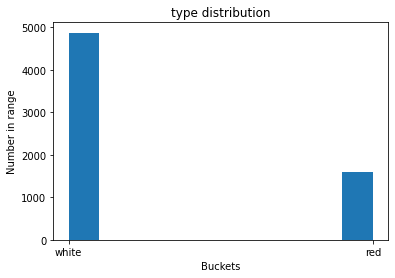

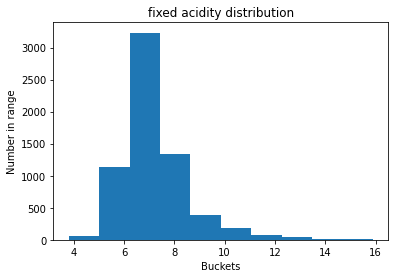

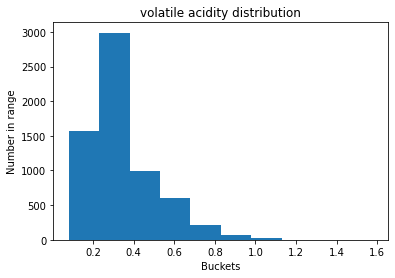

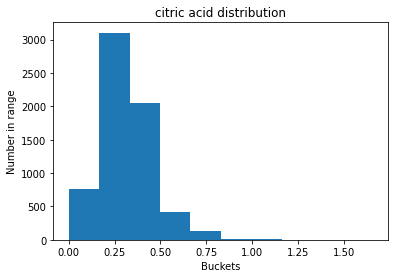

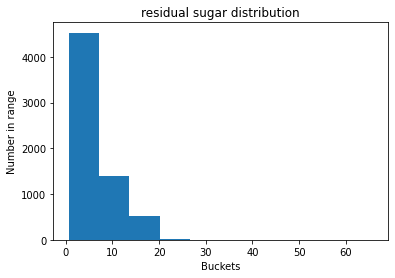

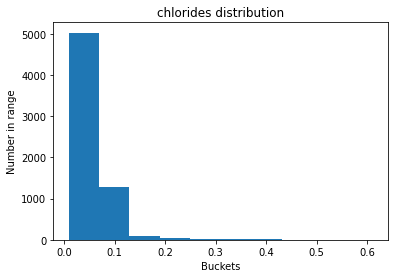

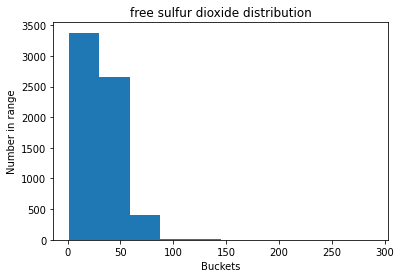

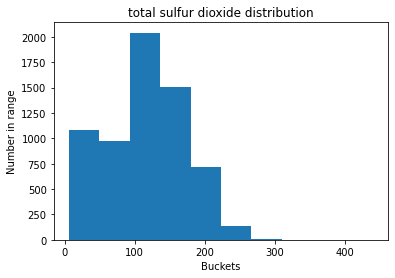

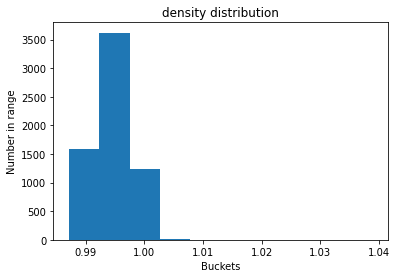

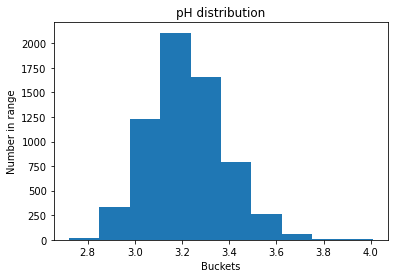

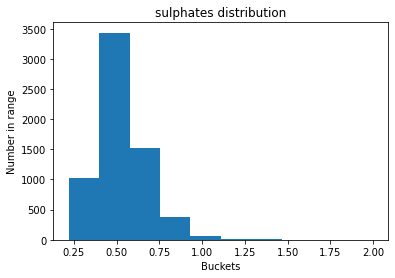

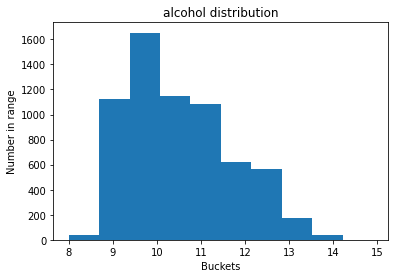

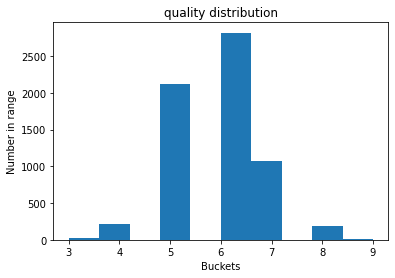

In [3]:
# plot histograms to see distributions of data
for column in raw_df:
  plt.hist(raw_df[column])
  plt.xlabel('Buckets')
  plt.ylabel('Number in range')
  plt.title(column + ' distribution')
  plt.show()

At a glance, these plots look good. There is a mix of features with relatively normal and non-normal distribution, which may help classify samples from the dataset.

This seems like a more reasonable classification system for the wines, given the limited number of samples available.

# Feature engineering
## Strategizing feature selection

The features provided in the dataset look promising, but to get an idea of whether they are actually usable I construct a scatterplot matrix.

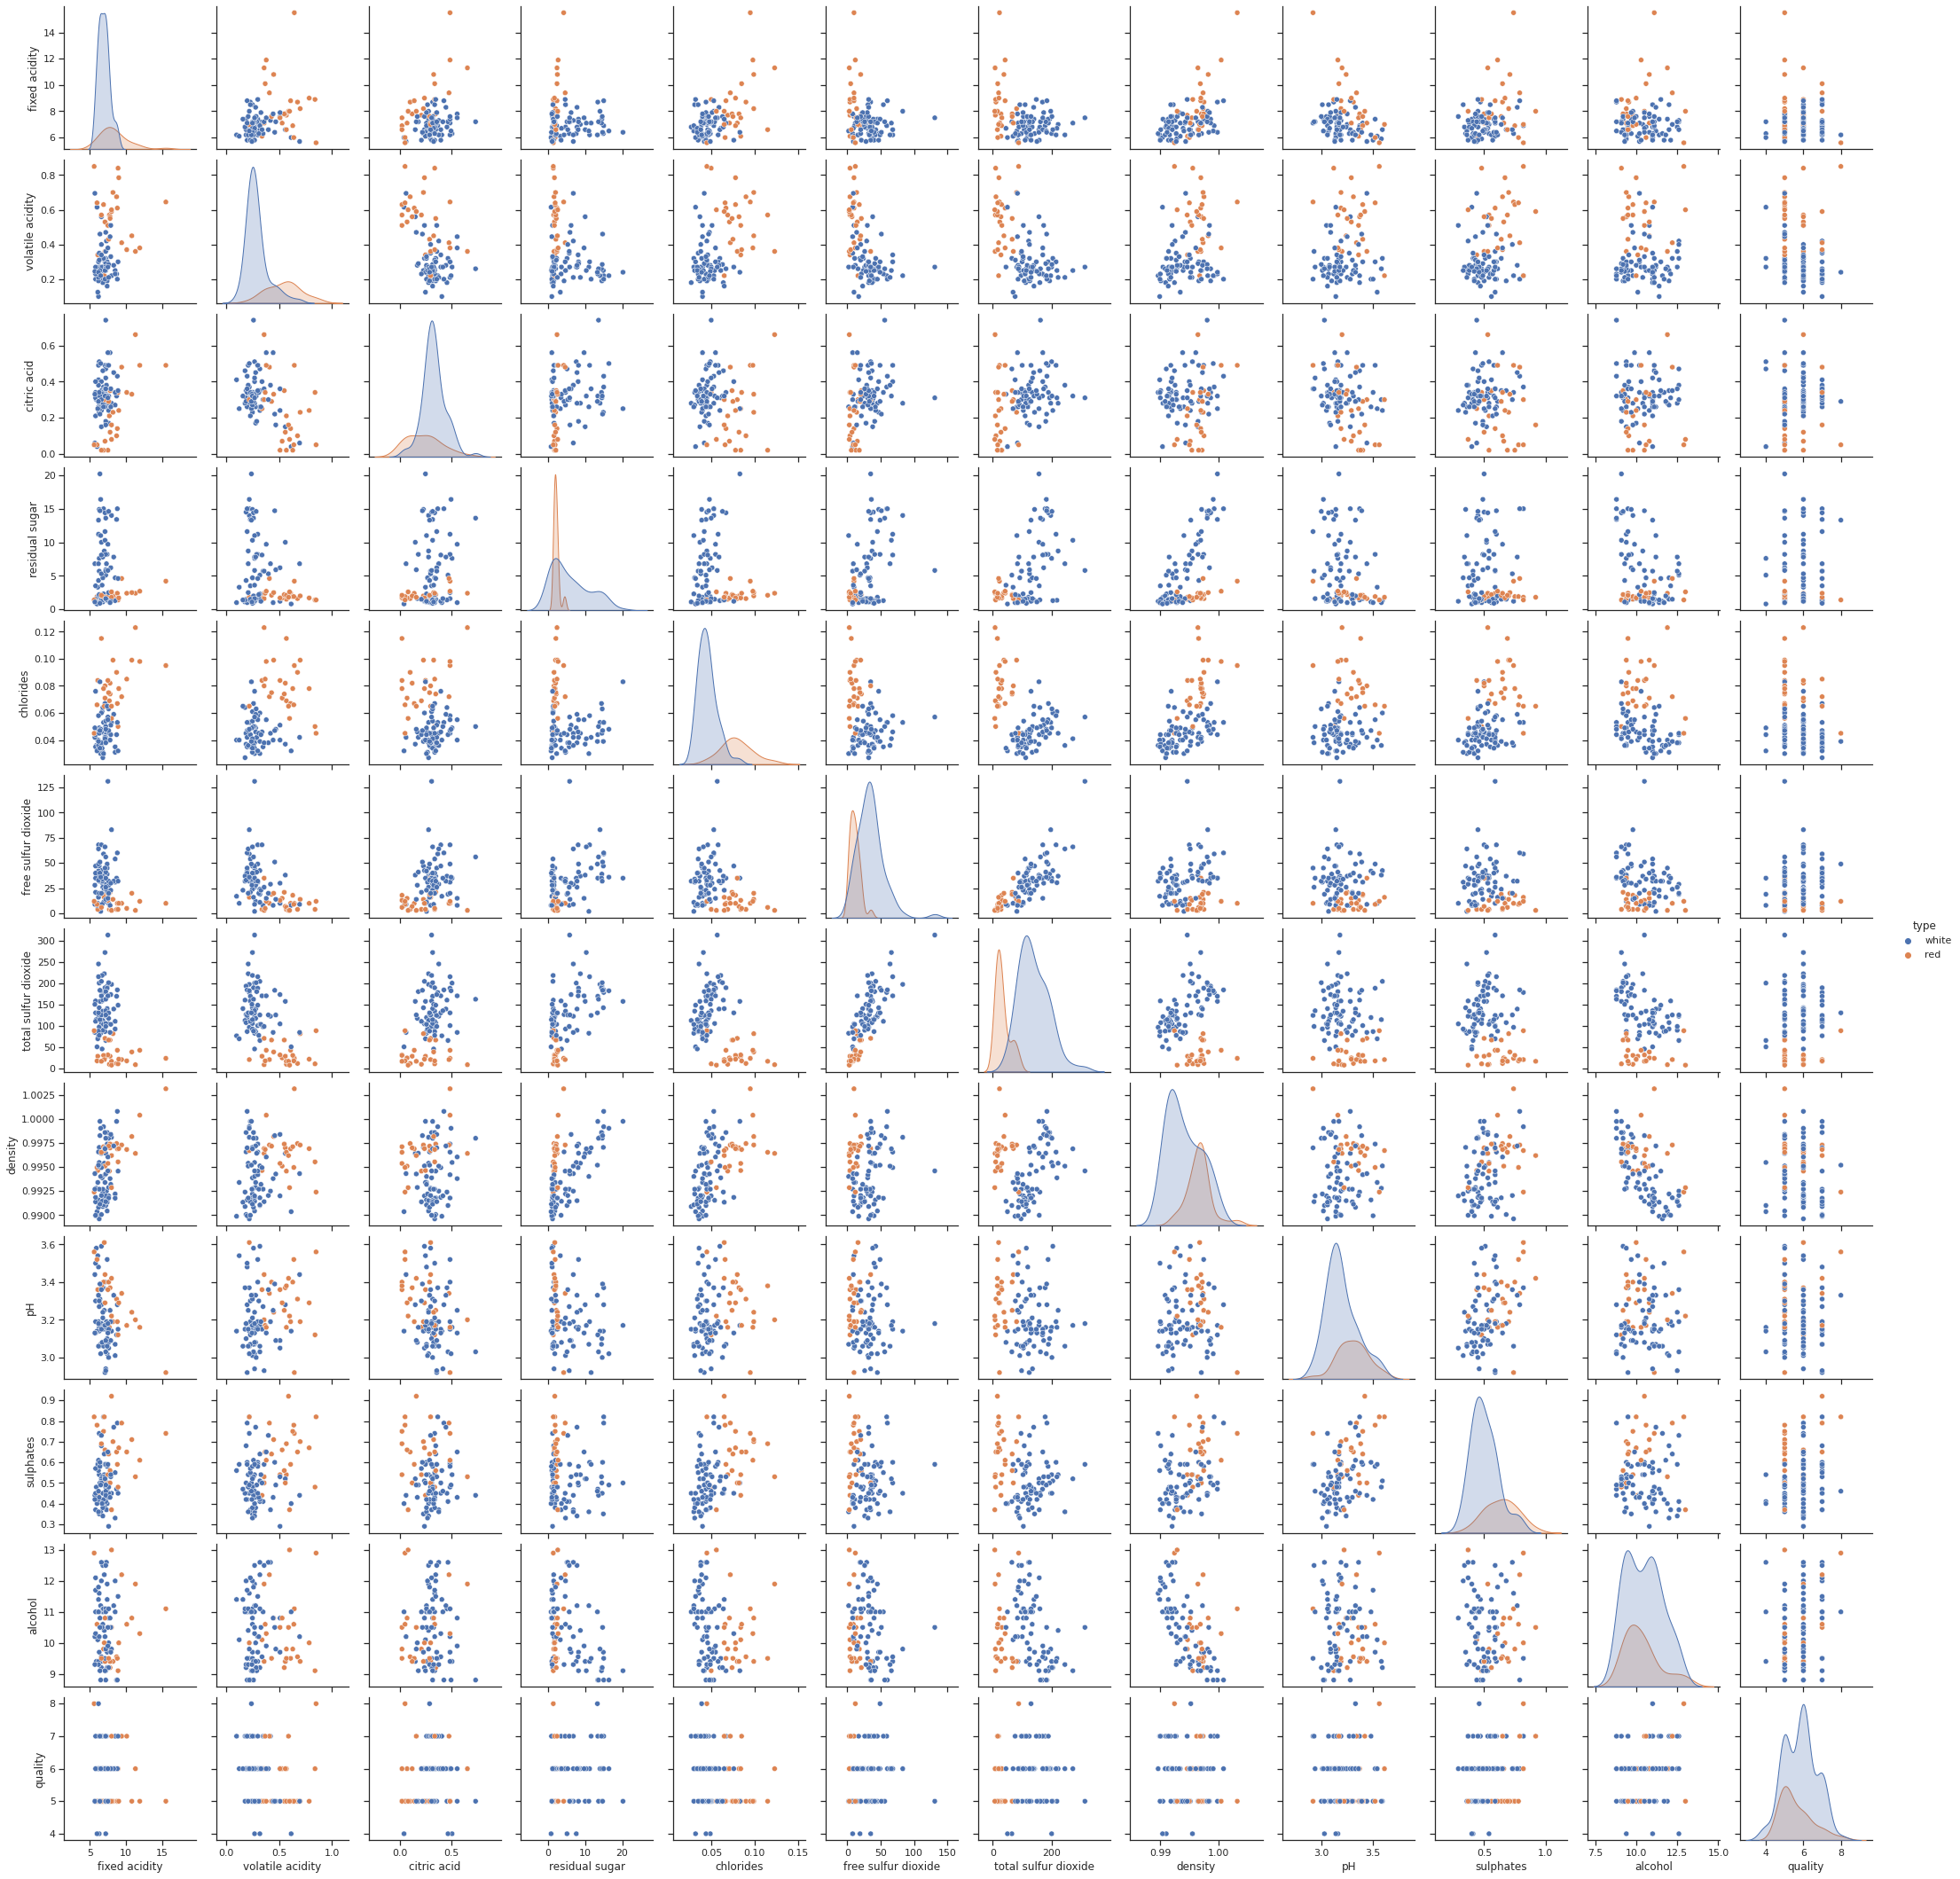

In [4]:
# This code simply prints a scatterplot matrix for the features in a small sample of the data

sns.set_theme(style='ticks')
sns.pairplot(small_sample_df,hue=target)

From the scatterplot matrix, my first observation is that the data *is* separable using the class 'type.' There exist multiple plots where the two classes of wine seem to be separable by a line. This is important, because it means that the classes are probably learnable by an algorithm. However, simply selecting features from these scatterplots would be a naive approach because:
1. I can't tell which features are most important from the plots.
2. Feature selection should normally be catered to the models under consideration, and the models I will be building have unique strengths and weaknesses.
3. Some feature graphs are difficult to interpret, such as any of the plots with 'quality' as a metric.

Therefore, instead of relying on graph interpretation I choose three different analytical approaches for each training run:

- **First run:** feature selection using relative mutual information scores assigned to each feature using scikit-learn.feature_selection.mutual_info_classif(). This is a "naive approach," in the sense that the *number* of features I use will be arbitrary.
- **Second run:** recursive feature elimination, where features with the weakest predictive power are sequentially removed from a model.
- **Third run:** sequential forwards feature selection, where features with the strogest predictive power are sequentially added to a model.

These strategies were chosen by consulting the Kaggle Education module on feature engineering, as well as an article provided by Scikit-learn on feature selection. These are included under 'References' at the bottom of the page.

There are two main reasons why I selected these strategies. First, all three strategies provide an analytical framework to select features according to their predictive power. Second, they are all "different" enough (i.e. they use different underlying fitting models) that they will likely choose different features.

For each of these runs, I use a sample dataset of 600 samples which I took when I loaded the raw data. Admittedly: the size of the sample dataset is somewhat arbitrary since I did not check how many samples I would need for statistical significance.

##**First run** feature selection using mutual information scores

To start with, I will use a feature utility metric to measure how strongly associated each feature is with the target variable.

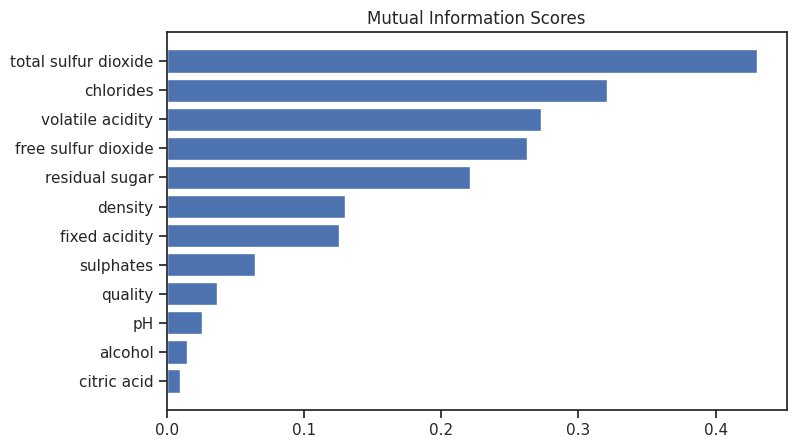

In [5]:
# NOTICE: this code is modified from: https://www.kaggle.com/code/ryanholbrook/mutual-information
X = small_sample_df.copy()
y = X.pop(target)

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

####################

from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

####Display
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

###Interpretation
From the bar graph, the top 4 ranked features are:
- total sulfur dioxide
- chlorides
- volatile acidity
- residual sugar.

##**Second run** feature selection using recursive feature elimination

Recursive Feature Elimination works by fitting a model using all features, removing the least useful feature, and then repeating the process until a desired number of features are left. Since four features were selected in the previous section, I will also select four using this technique.

One drawback to this method for my application (fitting three different models) is that RFE optimizes feature selection to the underlying model. Since I will be using a Decision Tree Classifier as the underlying model, that means the features I select will not necessarily be the optimal features for the models I will train later.

In [6]:
# NOTICE: first, I had tried to use this code: https://www.kaggle.com/code/carlmcbrideellis/recursive-feature-elimination-rfe-example/notebook
# NOTICE: this source was also consulted on RFE: https://machinelearningmastery.com/rfe-feature-selection-in-python/
# NOTICE: last, I took some code from https://www.youtube.com/watch?v=vxdVKbAv6as
import sklearn
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# inputs
X = small_sample_df.drop(columns=[target], axis=1)
y = small_sample_df[target]
# outputs

# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=4)

# define fit set
train_data = small_sample_df.copy()

#fit the model
rfe.fit(X, y)

for i, col in zip(range(X.shape[1]), X.columns):
  print(f"{col} selected={rfe.support_[i]} rank={rfe.ranking_[i]}")

fixed acidity selected=False rank=4
volatile acidity selected=False rank=9
citric acid selected=False rank=8
residual sugar selected=False rank=7
chlorides selected=True rank=1
free sulfur dioxide selected=False rank=6
total sulfur dioxide selected=True rank=1
density selected=False rank=5
pH selected=False rank=3
sulphates selected=False rank=2
alcohol selected=True rank=1
quality selected=True rank=1


From RFE, the chosen features are:
- chlorides
- total sulfur dioxide
- pH
- alcohol

###Interpretation

##**Third Run** feature selection using sequential forward feature selection

In [6]:
# this resource was consulted on sequential feature selection: https://www.youtube.com/watch?v=KYypVSwqqHI



###Interpretation

##Summary and reflection
In the previous sections, I chose the following features for each training run.

- **First run:**
- **Second run:**
- **Third run:** 

# Preparing for k-fold cross validation
Resource on cross-validation: https://scikit-learn.org/stable/modules/cross_validation.html

Resource on k-fold: https://machinelearningmastery.com/k-fold-cross-validation/



#Run 1: training the models
**Features used:**
###Naive Bayes

In [7]:
# training a NB alg

###Logistic regression

###Multilayer Preceptron

#Run 2: training the models

#Run 3: training the models

# References

Data source: https://www.kaggle.com/datasets/rajyellow46/wine-quality

Feature utility metric reference: https://www.kaggle.com/code/ryanholbrook/mutual-information

Categorical variables: https://www.kaggle.com/code/alexisbcook/categorical-variables/tutorial

https://www.kaggle.com/code/ryanholbrook/mutual-information

(Reference on feature selection: https://scikit-learn.org/stable/modules/feature_selection.html)

https://guhanesvar.medium.com/feature-selection-based-on-mutual-information-gain-for-classification-and-regression-d0f86ea5262a

Kaggle feature engineering tutorials: https://www.kaggle.com/learn/feature-engineering

# DISCLOSURE

This is the third dataset I selected for this project. Since there may have been influence on this iteration by the work I did on my last two datasets, I have included references to the resources I used in the first iteration of this project under "Works Cited."

Iteration 1 is also available on Github: https://github.com/journalWheat/CSI4106Project1-JaredWagner

As well as iteration 2: 
https://github.com/journalWheat/CSI4106-Project1-JaredWagner-WaterPotability